In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv


--2025-10-20 19:03:42--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.2’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.01s   

2025-10-20 19:03:42 (5.87 MB/s) - ‘course_lead_scoring.csv.2’ saved [80876/80876]



In [28]:
df = pd.read_csv('course_lead_scoring.csv')
print("Shape:", df.shape)
print("Columns:", list(df.columns))

Shape: (1462, 9)
Columns: ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']


In [29]:
# Ensure 'converted' target exists and is 0/1
if "converted" not in df.columns:
    # Try common alternatives
    alt_targets = [c for c in df.columns if c.lower() in ("converted", "conversion", "is_converted", "target")]
    if alt_targets:
        df.rename(columns={alt_targets[0]: "converted"}, inplace=True)
    else:
        raise ValueError("Target column 'converted' not found in CSV.")

# Coerce to numeric 0/1
if df["converted"].dtype == object:
    mapping = {"yes":1, "y":1, "true":1, "t":1, "1":1, 1:1,
               "no":0, "n":0, "false":0, "f":0, "0":0, 0:0}
    df["converted"] = df["converted"].map(lambda x: mapping.get(str(x).strip().lower(), np.nan))

df["converted"] = pd.to_numeric(df["converted"], errors="coerce")
df = df[~df["converted"].isna()].copy()
df["converted"] = df["converted"].astype(int)

print("Target value counts:")
print(df["converted"].value_counts(normalize=True).round(3))

Target value counts:
converted
1    0.619
0    0.381
Name: proportion, dtype: float64


In [30]:
# Data prep: impute missing values
feature_cols = [c for c in df.columns if c != "converted"]
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in feature_cols if not pd.api.types.is_numeric_dtype(df[c])]

missing_summary = {c: int(df[c].isna().sum()) for c in feature_cols}
print("Missing values per feature (before imputation):")
print(missing_summary)

for c in cat_cols:
    df[c] = df[c].fillna("NA")
for c in num_cols:
    df[c] = df[c].fillna(0.0)

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)

Missing values per feature (before imputation):
{'lead_source': 128, 'industry': 134, 'number_of_courses_viewed': 0, 'annual_income': 181, 'employment_status': 100, 'location': 63, 'interaction_count': 0, 'lead_score': 0}
Numeric features: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
Categorical features: ['lead_source', 'industry', 'employment_status', 'location']


In [31]:
# Split: 60/20/20 using random_state=1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df["converted"])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, stratify=df_full_train["converted"])

y_train = df_train["converted"].values
y_val = df_val["converted"].values
y_test = df_test["converted"].values

print("Split sizes: train=%d, val=%d, test=%d" % (len(df_train), len(df_val), len(df_test)))

Split sizes: train=876, val=293, test=293


In [32]:
# ROC AUC "feature importance" on numeric columns (train set)
auc_by_num = {}
for c in num_cols:
    s = df_train[c].astype(float).values
    try:
        auc = roc_auc_score(y_train, s)
        if auc < 0.5:
            s = -s
            auc = roc_auc_score(y_train, s)
    except Exception:
        auc = np.nan
    auc_by_num[c] = auc

best_num_var = max(auc_by_num, key=lambda k: (auc_by_num[k] if auc_by_num[k] is not None else -np.inf)) if auc_by_num else None
best_num_auc = auc_by_num.get(best_num_var, None)

print("Numeric AUCs (train):")
for k,v in auc_by_num.items():
    print(f"  {k}: {None if v is None else round(v,3)}")

print("\nBest numeric by AUC:", best_num_var, "AUC=", None if best_num_auc is None else round(best_num_auc,3))

Numeric AUCs (train):
  number_of_courses_viewed: 0.752
  annual_income: 0.567
  interaction_count: 0.706
  lead_score: 0.618

Best numeric by AUC: number_of_courses_viewed AUC= 0.752


In [33]:
# One-Hot + Logistic Regression (liblinear, C=1.0, max_iter=1000); AUC on validation
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(df_train[feature_cols].to_dict(orient="records"))
X_val = dv.transform(df_val[feature_cols].to_dict(orient="records"))

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_val_pred = model.predict_proba(X_val)[:, 1]

val_auc = roc_auc_score(y_val, y_val_pred)
print("Validation AUC (C=1.0):", round(val_auc, 3))

Validation AUC (C=1.0): 0.9


Precision/Recall intersection — threshold ≈ 0.81, precision=0.000, recall=0.000


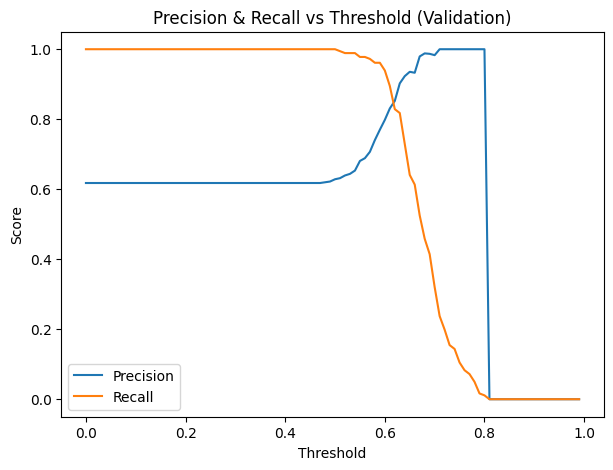

In [34]:
# Precision & Recall vs threshold; intersection
thresholds = np.arange(0.0, 1.0, 0.01)
precisions = []
recalls = []
for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds, zero_division=0))

precisions = np.array(precisions)
recalls = np.array(recalls)
idx_intersect = int(np.argmin(np.abs(precisions - recalls)))
thr_intersect = float(thresholds[idx_intersect])
prec_i = float(precisions[idx_intersect])
rec_i = float(recalls[idx_intersect])

print(f"Precision/Recall intersection — threshold ≈ {thr_intersect:.2f}, precision={prec_i:.3f}, recall={rec_i:.3f}")

# Plot
plt.figure(figsize=(7,5))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold (Validation)")
plt.legend()
plt.show()

# Save
plt.figure(figsize=(7,5))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold (Validation)")
plt.legend()
plt.close()

Max F1=0.863 at threshold=0.60


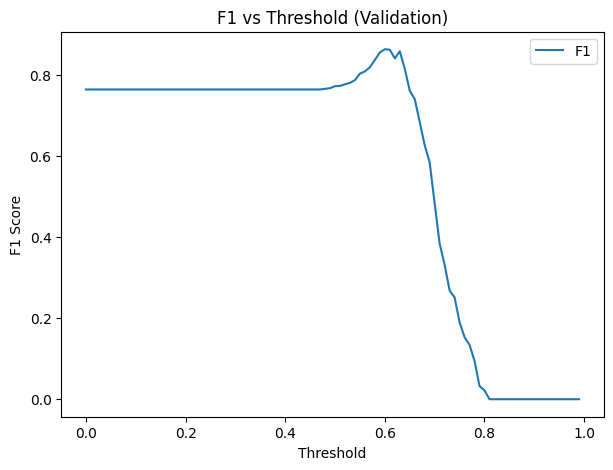

In [35]:
# F1 vs threshold; best threshold
f1s = []
for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    f1s.append(f1_score(y_val, preds, zero_division=0))
f1s = np.array(f1s)
idx_f1_max = int(np.argmax(f1s))
thr_f1_max = float(thresholds[idx_f1_max])
f1_max = float(f1s[idx_f1_max])

print(f"Max F1={f1_max:.3f} at threshold={thr_f1_max:.2f}")

# Plot
plt.figure(figsize=(7,5))
plt.plot(thresholds, f1s, label="F1")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold (Validation)")
plt.legend()
plt.show()

# Save
plt.figure(figsize=(7,5))
plt.plot(thresholds, f1s, label="F1")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold (Validation)")
plt.legend()
plt.close()

In [36]:
# 5-Fold CV on df_full_train; C=1.0
def eval_fold_auc(df_tr, df_va, feature_cols):
    y_tr = df_tr["converted"].values
    y_va = df_va["converted"].values
    dv_local = DictVectorizer(sparse=True)
    X_tr = dv_local.fit_transform(df_tr[feature_cols].to_dict(orient="records"))
    X_va = dv_local.transform(df_va[feature_cols].to_dict(orient="records"))
    m = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
    m.fit(X_tr, y_tr)
    y_va_pred = m.predict_proba(X_va)[:, 1]
    return roc_auc_score(y_va, y_va_pred)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = []
for tr_idx, va_idx in kf.split(df_full_train):
    df_tr = df_full_train.iloc[tr_idx]
    df_va = df_full_train.iloc[va_idx]
    cv_scores.append(eval_fold_auc(df_tr, df_va, feature_cols))

cv_scores = np.array(cv_scores, dtype=float)
print("5-Fold CV AUCs (C=1.0):", [round(s,3) for s in cv_scores.tolist()])
print("Mean:", round(cv_scores.mean(),3), "Std:", round(cv_scores.std(ddof=0),3))

5-Fold CV AUCs (C=1.0): [0.801, 0.837, 0.862, 0.778, 0.806]
Mean: 0.817 Std: 0.029


In [37]:
# Hyperparameter tuning over C ∈ {1e-6, 1e-3, 1}
Cs = [1e-6, 1e-3, 1.0]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

def cv_mean_std_for_C(C):
    scores = []
    for tr_idx, va_idx in kf.split(df_full_train):
        df_tr = df_full_train.iloc[tr_idx]
        df_va = df_full_train.iloc[va_idx]
        y_tr = df_tr["converted"].values
        y_va = df_va["converted"].values
        dv_local = DictVectorizer(sparse=True)
        X_tr = dv_local.fit_transform(df_tr[feature_cols].to_dict(orient="records"))
        X_va = dv_local.transform(df_va[feature_cols].to_dict(orient="records"))
        m = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
        m.fit(X_tr, y_tr)
        y_va_pred = m.predict_proba(X_va)[:, 1]
        scores.append(roc_auc_score(y_va, y_va_pred))
    scores = np.array(scores, dtype=float)
    return scores.mean(), scores.std(ddof=0)

means = []
stds = []
for C in Cs:
    mu, sd = cv_mean_std_for_C(C)
    means.append(mu); stds.append(sd)

rounded = {str(Cs[i]): {"mean": round(means[i],3), "std": round(stds[i],3)} for i in range(len(Cs))}
best_idx = int(np.argmax(means))
print("CV results by C:", rounded)
print("Best C by mean AUC:", Cs[best_idx])

CV results by C: {'1e-06': {'mean': np.float64(0.561), 'std': np.float64(0.035)}, '0.001': {'mean': np.float64(0.86), 'std': np.float64(0.026)}, '1.0': {'mean': np.float64(0.817), 'std': np.float64(0.029)}}
Best C by mean AUC: 0.001
